# MLP transient

## Previous

Para que funcione en Colab

In [2]:
import os
import sys
import IPython

# Detectar si estamos en Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Ruta base
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = "/content/drive/MyDrive/ia_thermal_colab"
else:
    BASE_PATH = os.path.expanduser("~/ia_thermal_colab")

DATASETS_PATH = os.path.join(BASE_PATH, "datasets")
MODELS_PATH = os.path.join(BASE_PATH, "models")

os.makedirs(DATASETS_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)

print("Modo:", "Colab" if IN_COLAB else "Local")
print("Ruta datasets:", DATASETS_PATH)
print("Ruta modelos:", MODELS_PATH)

Modo: Local
Ruta datasets: C:\Users\ismael.gallo/ia_thermal_colab\datasets
Ruta modelos: C:\Users\ismael.gallo/ia_thermal_colab\models


In [3]:
# 🔄 Parámetros del repo
GIT_REPO_URL = "https://github.com/ismaelgallolopez/ia_thermal.git"  # 👈 Cambia esto
REPO_NAME = GIT_REPO_URL.split("/")[-1].replace(".git", "")
CLONE_PATH = os.path.join(BASE_PATH, REPO_NAME)

if IN_COLAB:
    # 🧬 Clonar el repositorio si no existe ya
    if not os.path.exists(CLONE_PATH):
        !git clone {GIT_REPO_URL} {CLONE_PATH}
    else:
        print(f"Repositorio ya clonado en: {CLONE_PATH}")

    # 📦 Instalar requirements.txt
    req_path = os.path.join(CLONE_PATH, "requirements.txt")
    if os.path.exists(req_path):
        !pip install -r {req_path}
    else:
        print("No se encontró requirements.txt en el repositorio.")

    print("🔄 Reinicia el entorno para aplicar los cambios...")
    IPython.display.display(IPython.display.Javascript('''google.colab.restartRuntime()'''))

Importación de librerías necesarias


In [4]:
import numpy as np
import time
from datetime import datetime
from IPython.display import display, Markdown
import platform
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import optuna
from typing import Sequence, Union, Optional
# import seaborn as sns


import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim

np.set_printoptions(threshold=sys.maxsize)
torch.set_default_dtype(torch.float32)

# get the directory path of the file
dir_path = os.getcwd()

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

if IN_COLAB:
  sys.path.append("/content/drive/MyDrive/ia_thermal_colab/ia_thermal")

from plot_functions import *
from Physics_Loss import *
from utils import *
from scripts.PCB_solver_tr import *

if IN_COLAB:
  sys.path.append("/content/drive/MyDrive/ia_thermal_colab/ia_thermal/ismaelgallo")

# from architectures.mlp_pcb import *

from Dataset_Class_mlp import *

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print('Using device:', device)

Using device: cuda


In [6]:
system_specs = {
    "os": platform.system(),  # e.g. "Linux", "Windows", "Darwin"
    "os_version": platform.version(),
    "machine": platform.machine(),  # e.g. "x86_64"
    "processor": platform.processor(),  # e.g. "Intel64 Family 6 Model 158"
    "python_version": platform.python_version(),
    "device": str(device)
}
if torch.cuda.is_available():
    system_specs["gpu_name"] = torch.cuda.get_device_name(0)
    system_specs["gpu_memory_total_GB"] = round(torch.cuda.get_device_properties(0).total_memory / (1024**3), 2)
    system_specs["cuda_version"] = torch.version.cuda

## Dataset import

In [7]:
n_train = 1000
n_test = 200
n_val = 20
time_sim = 50 # seconds

batch_size = 1000

sequence_length = time_sim+1 # seconds
dt = 1 # seconds
T_init = 298.0 # Kelvin
nodes_side = 13 # number of nodes in one side of the PCB

Dataset extraction

In [8]:
if IN_COLAB:
  dir_path = BASE_PATH

base_dataset = load_dataset_mlp(base_path=dir_path)  # ← carga el dataset base completo (PCB_mlp_transient_dataset.pth)
dataset_train = load_trimmed_dataset_mlp(base_path=dir_path, dataset_type='train', max_cases=n_train, to_device=True)
dataset_val = load_trimmed_dataset_mlp(base_path=dir_path, dataset_type='val', max_cases=n_val, to_device=True)
dataset_test = load_trimmed_dataset_mlp(base_path=dir_path, dataset_type='test', max_cases=n_test, to_device=True)

loader = DataLoader(base_dataset, batch_size=batch_size, shuffle=False)  # DEBUGGING
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

✅ Cargando mlp transient dataset base desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_mlp_transient_dataset.pth
Cargando dataset base desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_mlp_transient_dataset_train.pth
Cargando dataset base desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_mlp_transient_dataset_val.pth
Cargando dataset base desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_mlp_transient_dataset_test.pth


c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\Dataset_Class_mlp.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(full_path)
c:\Users\ismael.gall

Debugging para comprobar que cumpla tamaños que nos interesan.

In [9]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([1000, 10]), torch.Size([1000, 169]))

## Hyperparameters of training

In [10]:
epochs = 1000
lr = 1e-2
lrdecay = 0.01
lrdecay_patience = 10
early_stop_patience = 50

hidden_layers = [64, 64, 64, 64, 64]
activation = nn.ReLU

# Non-physics MLP 

## Model definition

In [11]:
class MLP_PCB(nn.Module):
    def __init__(self, input_dim:int=10, output_dim:int=169, hidden_layers=[128, 128], activation=nn.SiLU):
        """
        Modelo MLP configurable para regresión.

        Args:
            input_dim (int): Número de características de entrada.
            output_dim (int): Número de salidas (por ejemplo, nodos de temperatura).
            hidden_layers (list): Lista con el número de neuronas por capa oculta.
            activation (callable): Clase de función de activación (por defecto nn.ReLU).
        """
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(activation())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [12]:
model = MLP_PCB(hidden_layers=hidden_layers, activation=activation).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lrdecay, patience=lrdecay_patience, verbose=True)

print(model)

MLP_PCB(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=169, bias=True)
  )
)


c:\Users\ismael.gallo\anaconda3\envs\ismael_minimal\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Ensure data is moved to the appropriate device


In [13]:
batch = next(iter(train_loader))
x, y = batch

print(f"x está en: {x.device}")
print(f"y está en: {y.device}")
print(f"model está en: {next(model.parameters()).device}")

x está en: cuda:0
y está en: cuda:0
model está en: cuda:0


## Training

Training and saving best model with best parameters.

In [ ]:
train_loss = []
val_loss_hist = []
best_val_loss = np.inf
epochs_without_improvement = 0
elapsed_previous = 0.0  # minutos ya entrenados en sesiones anteriores

layer_string = ""
for d in hidden_layers:
    layer_string += f"-{d}"
    
activation_string = activation.__name__

model_dir = os.path.join(dir_path, 'models', 'MLP_PCB')
if IN_COLAB:
    model_dir = os.path.join(MODELS_PATH, 'MLP_PCB')
os.makedirs(model_dir, exist_ok=True)

filename = f"PCB_MLP_nt{n_train}_e{epochs}_lr{lr}_bs{batch_size}_h{layer_string}_{activation_string}.pth"
model_path = os.path.join(model_dir, filename)
json_path  = model_path.replace('.pth', '.json')

start_epoch = 0
start_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# --- Lógica de reanudación ---
if os.path.exists(model_path):
    display(Markdown(f"🔁 Cargando modelo existente `{filename}` y reanudando entrenamiento."))
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            prev = json.load(f)
        best_val_loss         = prev.get('best_val_loss', best_val_loss)
        train_loss            = prev.get('train_loss', [])
        val_loss_hist             = prev.get('val_loss', [])
        elapsed_previous      = prev.get('training_duration_minutes', 0.0)
        start_datetime        = prev.get('start_datetime', start_datetime)
        start_epoch           = prev.get('epochs_trained', 0)
        # Reiniciamos el contador de paciencia tras mejora
        epochs_without_improvement = 0
    else:
        display(Markdown("⚠️ No se encontró JSON de hiperparámetros; se reinicia contadores."))
else:
    display(Markdown(f"✨ Nuevo entrenamiento: `{filename}`"))

print("📁 Los resultados se guardarán en:", json_path)

🔁 Cargando modelo existente `PCB_MLP_nt1000_e1000_lr0.01_bs1000_h-64-64-64-64-64_ReLU.pth` y reanudando entrenamiento.

📁 Los resultados se guardarán en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models\MLP_PCB\PCB_MLP_nt1000_e1000_lr0.01_bs1000_h-64-64-64-64-64_ReLU.json


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_5152\2858951258.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loca

In [15]:
for epoch in range(start_epoch, epochs):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
    for x, y in train_bar:
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        train_bar.set_postfix(loss=loss.item())
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss.append(epoch_loss)
    # print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.6f}")

    # Validación
    model.eval()
    val_loss = 0.0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
    with torch.no_grad():
        for x_val, y_val in val_bar:
            y_pred_val = model(x_val)
            loss_val = criterion(y_pred_val, y_val)
            val_loss += loss_val.item() * x_val.size(0)
            val_bar.set_postfix(val_loss=loss_val.item())
    val_loss = val_loss / len(val_loader.dataset)
    # print(f"Epoch {epoch+1}/{epochs} - Val Loss: {val_loss:.6f}")
    # If you want to keep a history, use a list like val_loss_hist and append here:
    val_loss_hist.append(val_loss)

    # Scheduler
    scheduler.step(val_loss)

    # Guardar mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), model_path)
        # Guardar JSON con info de entrenamiento
        training_info = {
            "best_val_loss": best_val_loss,
            "epochs_trained": epoch + 1,
            "training_duration_minutes": elapsed_previous + ((datetime.now() - datetime.strptime(start_datetime, "%Y-%m-%d %H:%M:%S")).total_seconds() / 60.0),
            "start_datetime": start_datetime,
            "hyperparameters": {
                "epochs": epochs,
                "lr0": lr,
                "batch_size": batch_size,
                "hidden_layers": layer_string,
                "activation": activation_string,
            },
            "final lr": optimizer.param_groups[0]['lr'],
            "train_loss": train_loss,
            "val_loss": val_loss_hist,
            # "train_loss": train_loss,
            # "val_loss": val_loss_hist
        }
        with open(json_path, 'w') as f:
            json.dump(training_info, f, indent=2)
        # print(f"✅ Modelo guardado: {model_path}")
    else:
        epochs_without_improvement += 1

    # Early stopping
    if epochs_without_improvement >= early_stop_patience:
        print(f"⏹️ Early stopping en la época {epoch+1} tras {early_stop_patience} épocas sin mejora.")
        break

KeyboardInterrupt: 

Plot training loss and validation loss

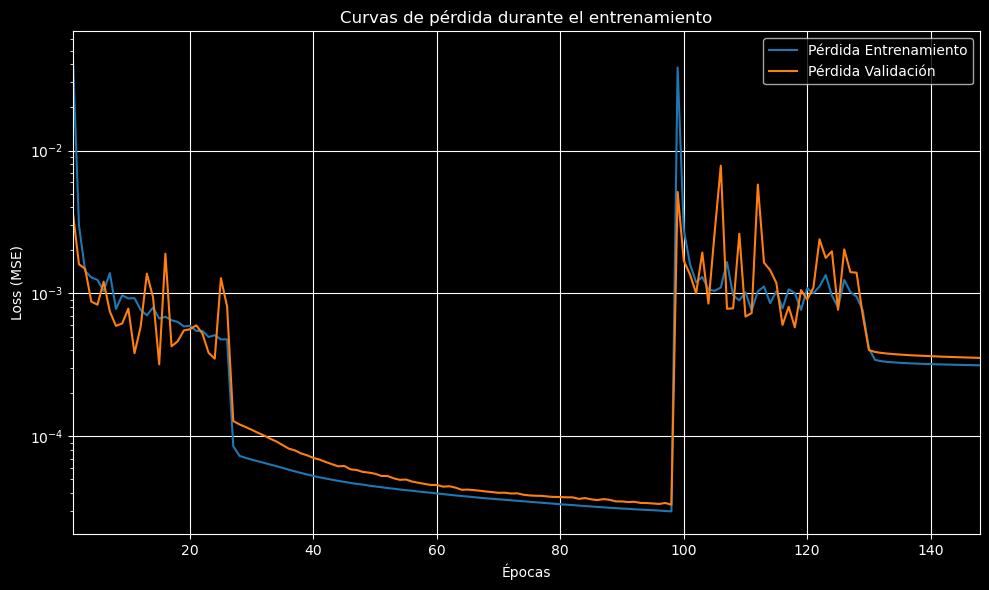

In [ ]:
plot_loss_curves(train_loss, val_loss_hist)

## Evaluation

In [ ]:
# load the best model
model = MLP_PCB(hidden_layers=hidden_layers, activation=activation).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Test
test_loss = 0.0
test_bar = tqdm(test_loader, desc=f"Test", leave=False)
with torch.no_grad():
    for x_test, y_test in test_bar:
        y_pred_test = model(x_test)
        loss_test = criterion(y_pred_test, y_test)
        test_loss += loss_test.item() * x_test.size(0)
        test_bar.set_postfix(test_loss=loss_test.item())

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_17148\3240133991.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


## Optuna study

Estudio para encontrar las mejores combinaciones de numero de capas con iteraciones en número de neuronas ocultas, learning rate, numero de capas, funcion de activacion, lr decay factor y patience

In [ ]:
def objective(trial):
    # Sugerir hiperparámetros
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    n_layers = trial.suggest_int('n_layers', 1, 5)
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256, 512])
    activation_name = trial.suggest_categorical('activation', ['ReLU', 'SiLU', 'Tanh'])
    activation = getattr(nn, activation_name)
    lrdecay = trial.suggest_loguniform('lrdecay', 0.1, 0.5)
    lrdecay_patience = trial.suggest_int('lrdecay_patience', 5, 50)

    # Definir arquitectura
    hidden_layers = [hidden_dim] * n_layers
    model = MLP_PCB(hidden_layers=hidden_layers, activation=activation).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lrdecay, patience=lrdecay_patience, verbose=False)
    criterion = nn.MSELoss()

    epochs_optuna = epochs
    train_loss = []
    val_loss_hist = []
    start_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    for epoch in range(epochs_optuna):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                y_pred_val = model(x_val)
                loss_val = criterion(y_pred_val, y_val)
                val_loss += loss_val.item() * x_val.size(0)
        val_loss /= len(val_loader.dataset)
        val_loss_hist.append(val_loss)
        scheduler.step(val_loss)

    # Guardar modelo y JSON en carpeta optuna_studies/models
    os.makedirs("optuna_studies/mlp_models", exist_ok=True)
    model_path = f"optuna_studies/mlp_models/model_trial_{trial.number}.pth"
    json_path = f"optuna_studies/mlp_models/model_trial_{trial.number}.json"
    torch.save(model.state_dict(), model_path)
    
    # Guardar también con el mismo formato y ruta que el entrenamiento normal
    layer_string = ""
    for d in hidden_layers:
        layer_string += f"-{d}"
    activation_string = activation.__name__
    # Abreviar el learning rate para el nombre del archivo
    lr_str = f"{lr:.0e}" if lr < 1e-2 else f"{lr:.2f}"
    model_dir = os.path.join(dir_path, 'models', 'MLP_PCB')
    if IN_COLAB:
        model_dir = os.path.join(MODELS_PATH, 'MLP_PCB')
    os.makedirs(model_dir, exist_ok=True)
    filename = f"PCB_MLP_trial{trial.number}_nt{n_train}_e{epochs_optuna}_lr{lr_str}_bs{batch_size}_h{layer_string}_{activation_string}.pth"
    model_path_normal = os.path.join(model_dir, filename)
    json_path_normal = model_path_normal.replace('.pth', '.json')
    torch.save(model.state_dict(), model_path_normal)

    training_info = {
        "trial_number": trial.number,
        "final_val_loss": val_loss_hist[-1] if val_loss_hist else None,
        "epochs_trained": epochs_optuna,
        "training_duration_minutes": None,  # Puedes calcularlo si quieres
        "start_datetime": start_datetime,
        "hyperparameters": {
            "lr": lr,
            "n_layers": n_layers,
            "hidden_dim": hidden_dim,
            "activation": activation_name,
            "lrdecay": lrdecay,
            "lrdecay_patience": lrdecay_patience,
        },
        "final_lr": optimizer.param_groups[0]['lr'],
        "train_loss": train_loss,
        "val_loss": val_loss_hist
    }
    with open(json_path, 'w') as f:
        json.dump(training_info, f, indent=2)
    with open(json_path_normal, 'w') as f:
        json.dump(training_info, f, indent=2)

    return val_loss_hist[-1] if val_loss_hist else None

Crear y ejecutar el estudio

In [ ]:
# Crea el estudio y lo guarda en un archivo SQLite
os.makedirs("optuna_studies", exist_ok=True)
study = optuna.create_study(
    direction='minimize',
    study_name="mlp_pcb_study",
    storage="sqlite:///optuna_studies/mlp_pcb_optuna_study.db",
    load_if_exists=True
)

[I 2025-06-13 11:27:29,765] Using an existing study with name 'mlp_pcb_study' instead of creating a new one.


In [ ]:
study.optimize(objective, timeout=10)

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_17148\2447052604.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_17148\2447052604.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lrdecay = trial.suggest_loguniform('lrdecay', 0.1, 0.5)


In [ ]:
best_trial   = study.best_trial
best_params  = best_trial.params         # dict con los hiperparámetros ganadores
print("Número de ensayo ganador :", best_trial.number)
print("Valor objetivo (pérdida) :", best_trial.value)
print("Hiperparámetros óptimos  :", best_params)

Número de ensayo ganador : 41
Valor objetivo (pérdida) : 1.0661789418519619e-07
Hiperparámetros óptimos  : {'lr': 0.007992966235711838, 'n_layers': 5, 'hidden_dim': 64, 'activation': 'SiLU', 'lrdecay': 0.3961551271796536, 'lrdecay_patience': 22}


### Loading best model

Cargar el estudio que mejores resultados obtuvo

In [ ]:
study = optuna.load_study(
    study_name="mlp_pcb_study",
    storage="sqlite:///optuna_studies/mlp_pcb_optuna_study.db"
)
best_trial = study.best_trial
best_params = best_trial.params

Reconstrucción de la ruta 

In [ ]:
model_path = f"optuna_studies/mlp_models/model_trial_{best_trial.number}.pth"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"No existe el fichero {model_path}")


Asignando valors de los parámetros del mejor modelo de la red

In [ ]:
hidden_layers = [best_params["hidden_dim"]] * best_params["n_layers"]
activation = getattr(torch.nn, best_params["activation"])
model = MLP_PCB(hidden_layers=hidden_layers, activation=activation).to("cpu")

optimizer = torch.optim.Adam(model.parameters(),
                             lr=best_params["lr"])

# 4) Crea un nuevo scheduler idéntico al usado en el trial
scheduler = ReduceLROnPlateau(optimizer,
                              mode="min",
                              factor=best_params["lrdecay"],
                              patience=best_params["lrdecay_patience"],
                              verbose=False)

Cargar los pesos del modelo

In [ ]:
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_19300\2633090818.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=devi

MLP_PCB(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SiLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): SiLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): SiLU()
    (10): Linear(in_features=64, out_features=169, bias=True)
  )
)

## Inference

In [ ]:
Q_heaters = np.array([1, 1, 1, 1])
T_interfaces = np.array([290, 290, 290, 290])
T_env = 300

In [ ]:
def predict_temperature_mlp(
    model: torch.nn.Module,
    dataset: PCBDataset_mlp,
    Q_heaters: Sequence[float],
    T_interfaces: Sequence[float],
    T_env: float,
    time_raw_seq: Optional[Union[np.ndarray, torch.Tensor]] = None,
    n_steps: int = 51,
    device: Optional[torch.device] = None
) -> np.ndarray:
    """
    Inferencia completa de la evolución térmica de la PCB.

    Si `time_raw_seq` es None, se crea automáticamente el vector
    de tiempo normalizado de longitud 1001 por defecto.

    Devuelve un array (n_steps, 169) con los mapas de temperatura
    desnormalizados.
    """
    # 0) Device y modelo  
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    # 1) Generar o convertir la secuencia de tiempo cruda
    if time_raw_seq is None:
        time_raw = torch.arange(0, n_steps, dtype=torch.float32)  # (n_steps,)
    else:
        if isinstance(time_raw_seq, np.ndarray):
            time_raw = torch.from_numpy(time_raw_seq.astype(np.float32))
        else:
            time_raw = time_raw_seq.clone().float()
    time_raw = time_raw.to(device)

    # 2) Crear todos los inputs normalizados
    inputs = []
    for t in time_raw.cpu().numpy():
        inp = dataset.create_input_from_values(
            Q_heaters=Q_heaters,
            T_interfaces=T_interfaces,
            T_env=T_env,
            time=t
        )
        inputs.append(inp.unsqueeze(0))
    X = torch.cat(inputs, dim=0).to(device)  # (n_steps, 10)

    # 3) Inferir en batch
    with torch.no_grad():
        preds_norm = model(X)  # (n_steps, 169)

    # 4) Desnormalizar la salida
    temps_denorm = dataset.denormalize_output(preds_norm)  # (n_steps,169)
    return temps_denorm


Prediction from the network

In [ ]:
T_pred = predict_temperature_mlp(
    model=model,
    dataset=base_dataset,
    Q_heaters=[1, 1, 1, 1],
    T_interfaces=[280, 280, 280, 280],
    T_env=298.0,
)
T_pred.shape

torch.Size([51, 169])

Ground truth

In [ ]:
T_true, _, _, _ = PCB_case_2(solver='transient', Q_heaters=Q_heaters,  T_interfaces=T_interfaces,  T_env=T_env, time_sim=time_sim, dt=1, nodes_side=13)

TypeError: PCB_case_2() got an unexpected keyword argument 'T_env'